In [4]:
from optimization_func import simulated_annealing
from helper import mse, mae, r2, lotka_volterra, int_cost_lotka_volterra, get_predator_prey_data
t, P = get_predator_prey_data()
import shelve
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
import pandas as pd 
from joypy import joyplot



In [5]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [6]:
def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [7]:
def F_test(Samples_A, Samples_B):
    """ Calculates the F-test based on the data from two datasets.
        Returns:
            F-statistics (int)
            p=value (int)
    """
    A_var,  A_len = np.var(Samples_A, ddof = 1), len(Samples_A)
    B_var, B_len = np.var(Samples_B, ddof = 1), len(Samples_B)
    F = max(A_var/B_var, B_var/A_var)
    if A_var > B_var:
        n1 = A_len
        n2 = B_len
    else: 
        n2 = A_len
        n1 = B_len
    p_value = 1 - scipy.stats.f.cdf(F, (n1 - 1), (n2 - 1))
    return F, p_value

In [8]:
def Convergence_data(rvs, cost, n_sim=500, eta = 0.2):
    Dict = {}
    for rv in rvs:
        sim_data = []
        r2s = []
        for n in range(n_sim):
            state, _, _, costs = simulated_annealing(rv, t, P, cost=cost, cooling_schedule="quadratic", T_start=200, T_steps=2000, write_costs = True, eta = eta)
            sim_data.append(costs)
            r2_value = int_cost_lotka_volterra(state, P, t, cost=r2)
            r2s.append(r2_value)
        Dict[str(rv)] = (sim_data, r2s)
    
    return Dict               

In [9]:
xs_chosen = [[0.66593614, 2.94213991, 8.129154  , 4.88824876], #10
    [1.59035578, 3.964897  , 8.93986609, 2.72514184], #9
    [2.91245287, 2.70612094, 2.01560385, 1.47317489], # good guess (MSE ~ 3.4)
  ]

In [10]:
for xs in xs_chosen:
    print(int_cost_lotka_volterra(xs, P, t, cost=r2))

-1.2971372933606249
-1.2390177286702897
0.015527518784367755


In [7]:
%%time
np.random.seed(567367)
if False: 
    shelf = shelve.open("Arrays/MSE_vs_MAE")
    Test_mse = Convergence_data(rvs=xs, cost=mse)
    shelf["Test_mse"] = Test_mse
    Test_mae = Convergence_data(rvs=xs, cost=mae)
    shelf["Test_mae"] = Test_mae
    shelf.close() 

CPU times: user 24 µs, sys: 8 µs, total: 32 µs
Wall time: 35.3 µs


In [15]:
shelf = shelve.open("Arrays/MSE_vs_MAE")
Test_mse = shelf["Test_mse"] 
Test_mae = shelf["Test_mae"] 
shelf.close() 

In [26]:
def Convergence_plotter(rvs, Test_mse, Test_mae, T_steps=2000):
    iterations = range(1,T_steps + 2)
    Cost = ["MSE", "MAE"]
    i = 0
    for data in  [Test_mse, Test_mae]:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        j = 0
        for rv in rvs:
            results = data[str(rv)][0]
            mean = np.mean(results, axis = 0)
            std = np.std(results, axis = 0, ddof= 1)
            r2_mean = np.mean(data[str(rv)][1], axis = 0)
            a = [sp_confidence_interval(samples) for samples in np.array(results).T]
            #plt.hlines(y=mean[-1]*1.1, xmin=0, xmax=T_steps, linestyles='--', color = colors[j], linewidth = 1)
            plt.plot(iterations, mean, colors[j], linewidth = 1)
            plt.fill_between(iterations, mean - std, mean + std, alpha = 0.2, color = colors[j])
            j += 1
            
        plt.grid(alpha=0.3)
        plt.ylabel(Cost[i])
        plt.xlabel("Iteration")
        #plt.yscale("log")
        plt.savefig("figures/"+ Cost[i] + "_During_sim.pdf", bbox_inches="tight")
        plt.show()  
        i +=1


C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


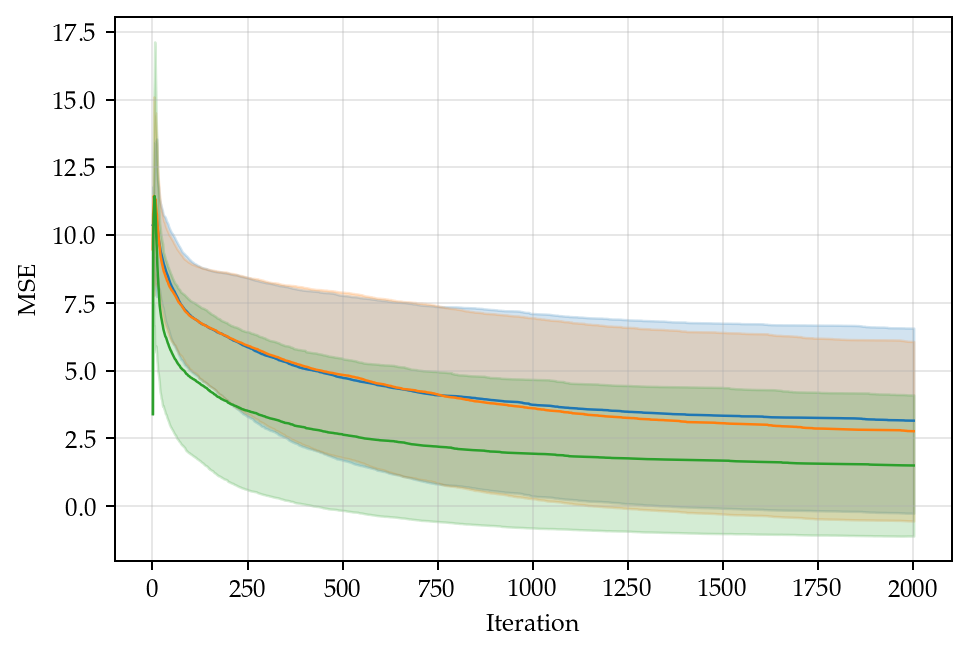

C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\malou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


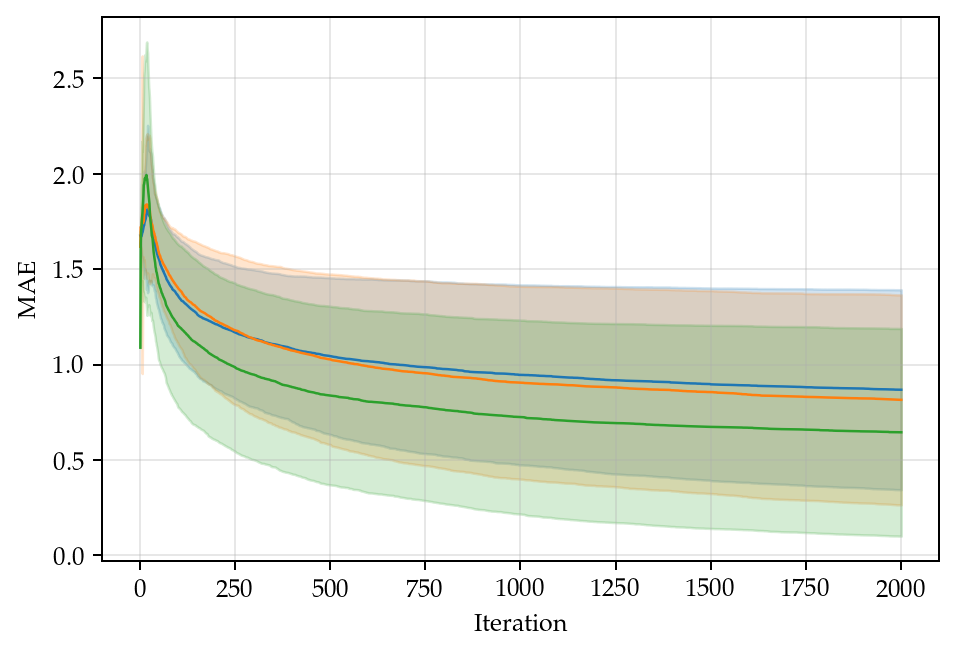

In [27]:
Convergence_plotter(xs_chosen, Test_mse, Test_mae, T_steps=2000)

<Figure size 1080x720 with 0 Axes>

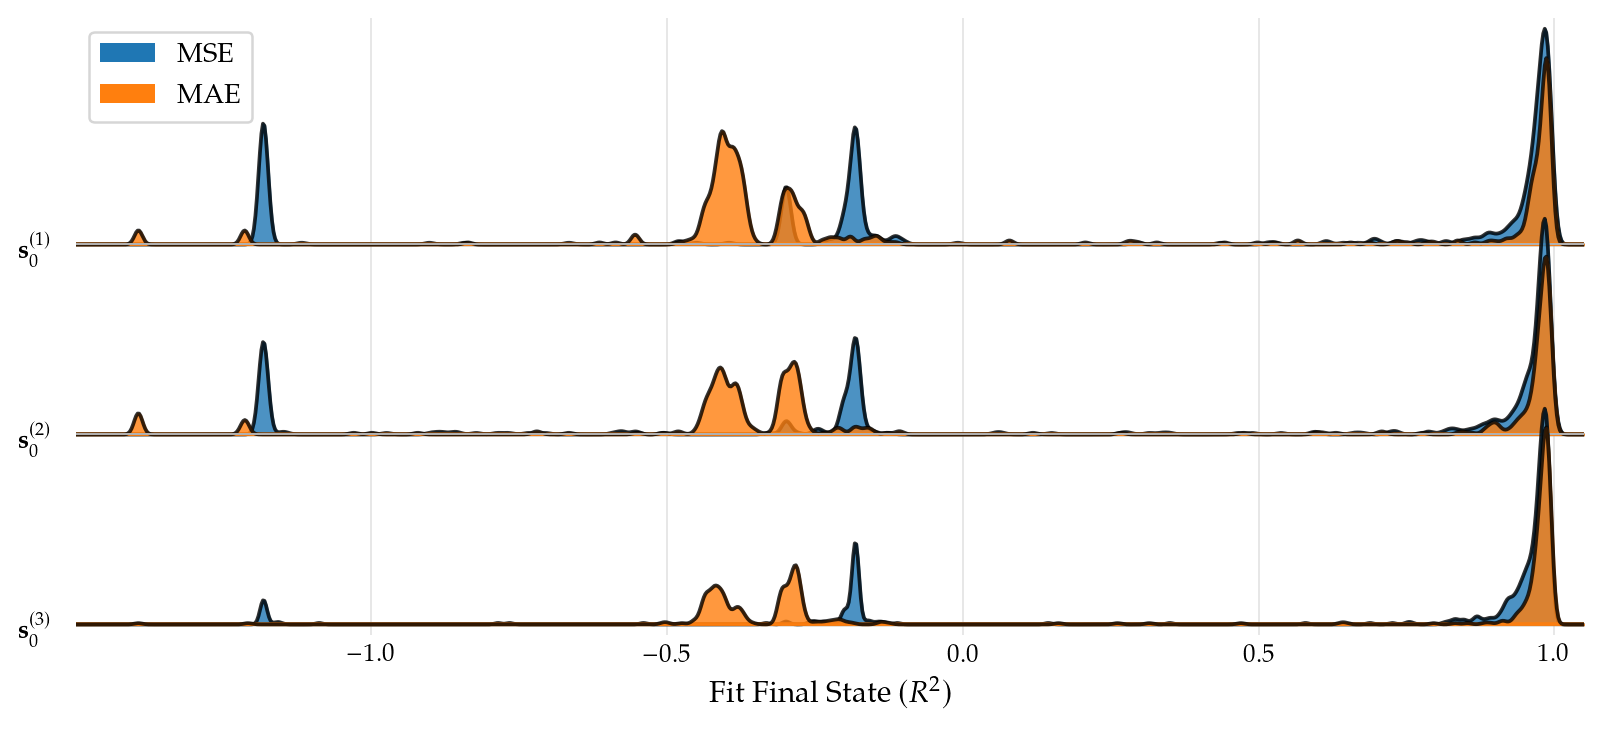

In [13]:


MSE_r2_s1 = Test_mse[str(xs_chosen[0])][1]
MAE_r2_s1 = Test_mae[str(xs_chosen[0])][1]

MSE_r2_s2 = Test_mse[str(xs_chosen[1])][1]
MAE_r2_s2 = Test_mae[str(xs_chosen[1])][1]

MSE_r2_s3 = Test_mse[str(xs_chosen[2])][1]
MAE_r2_s3 = Test_mae[str(xs_chosen[2])][1]
    

data_s1 = np.array([np.repeat("$\\mathbf{s}_0^{(1)}$", len(MSE_r2_s1)), MSE_r2_s1, MAE_r2_s1])
data_s2 = np.array([np.repeat("$\\mathbf{s}_0^{(2)}$", len(MSE_r2_s2)), MSE_r2_s2, MAE_r2_s2])
data_s3 = np.array([np.repeat("$\\mathbf{s}_0^{(3)}$", len(MSE_r2_s3)), MSE_r2_s3, MAE_r2_s3])
Data = np.concatenate([data_s1, data_s2, data_s3], axis = 1)

df = pd.DataFrame(Data.T, columns = ["Initial State", "MSE", "MAE"])
df = df.astype({"MSE": float})
df = df.astype({"MAE": float})

plt.figure()
ax, fig = joyplot(
    data=df[["Initial State","MSE", "MAE"]], 
    by="Initial State",
    column=["MSE", "MAE"],
    color=["tab:blue", "tab:orange"],
    legend=True,
    alpha=0.8,
    overlap=0.5,
    figsize=(9, 4),
    #hist = True,
    #bins = 60,
    bw_method=0.01,
    loc = "upper left",
    ylim='own',
    x_range=[-1.5,1.05],
    grid=True,
) 

plt.grid(alpha=0.3)
plt.xlabel('Fit Final State $(R^2)$', fontsize=12)
plt.savefig("figures/MSE_MAE_R2.pdf", bbox_inches="tight")
plt.show()

In [38]:
import seaborn as sns
import scipy 

i = 1
for rv in xs_chosen:
    print("\n")        
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print("For rv", i)
    print("Starting R2:", int_cost_lotka_volterra(rv, P, t, cost=r2))
    j = 0
    Cost = ["MSE", "MAE"]
    for data in [Test_mse, Test_mae]:
        print("\n")
        print(Cost[j])
        results = data[str(rv)][1]
        print("Mean", np.mean(results, axis = 0))
        print("Median", np.median(results, axis = 0))
        print("best", np.max(results, axis = 0))
        print("worst", np.min(results, axis = 0))
        j +=1
        

    print("\nStatistical Tests:")
    _, p1 = F_test(Test_mse[str(rv)][1], Test_mae[str(rv)][1])
    if p1*3 > 0.05: 
        print("p-value F-test:", p1*3)
        print("No statistical difference variance")
    else: 
        print("p-value F-test:", p1*3)
        print("Statistical difference variance")
        
    _, p2 = scipy.stats.ttest_ind(Test_mse[str(rv)][1], Test_mae[str(rv)][1], equal_var = True)
    if p2*3 > 0.05: 
        print("p-value t-test", p2*3)
        print("No statistical difference mean")
    else: 
        print("p-value t-test", p2*3)
        print("statistical difference mean")
    i += 1



xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
For rv 1
Starting R2: -1.2971372933606249


MSE
Mean 0.2927423752649044
Median 0.8877728128611863
best 0.9948026150397578
worst -1.1826773712865815


MAE
Mean 0.10234794499083763
Median -0.2911619566362492
best 0.9942973770504948
worst -1.3944757825035152

Statistical Tests:
p-value F-test: 0.000281283789298703
Statistical difference variance
p-value t-test 0.0001578407608530708
statistical difference mean


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
For rv 2
Starting R2: -1.2390177286702897


MSE
Mean 0.3539315193346912
Median 0.9306628882197306
best 0.9948261085095882
worst -1.1826540104594612


MAE
Mean 0.15955960759890736
Median -0.2784000597472759
best 0.9949006121836901
worst -1.394757154678675

Statistical Tests:
p-value F-test: 0.03460289418910523
Statistical difference variance
p-value t-test 0.00016476981428624522
statistical difference mean


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
For rv 3
Starting R2: 0.015527518784367755


MSE
Mean 0.66